In [72]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import scipy.stats

%pylab inline

#s = json.load( open(os.getenv('PUI2018') + "/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)

os.environ['PUIDATA'] = '/nfshome/cb4221/PUIDATA'
!ls $PUIDATA

Populating the interactive namespace from numpy and matplotlib
201501-citibike-tripdata.csv  201506-citibike-tripdata.zip  scores.csv
201501-citibike-tripdata.zip  201509-citibike-tripdata.csv  times.txt
201502-citibike-tripdata.csv  201509-citibike-tripdata.zip  tripdata.csv
201502-citibike-tripdata.zip  construction_projects.csv     water.csv
201506-citibike-tripdata.csv  satscores.csv


In [73]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [74]:
# first month, in the winter
datestring = '201502'
getCitiBikeCSV(datestring)

file in place, you can continue


In [75]:
# second month, in the summer
datestring2 = '201506'
getCitiBikeCSV(datestring2)

file in place, you can continue


In [76]:
# reading in February data
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

# reading in June data 
df2 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')

In [77]:
# Joining two dataframes using concat

frames = [df, df2]
feb_june = pd.concat(frames)
#feb_june.head()

In [78]:
# creating new column called data that pulls data from start time? to_datetime seems like special function
feb_june['date'] = pd.to_datetime(feb_june['starttime'])
feb_june.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,801,2/1/2015 0:00,2/1/2015 0:14,521,8 Ave & W 31 St,40.750450,-73.994811,423,W 54 St & 9 Ave,40.765849,-73.986905,17131,Subscriber,1978.0,2,2015-02-01 00:00:00
1,379,2/1/2015 0:00,2/1/2015 0:07,497,E 17 St & Broadway,40.737050,-73.990093,504,1 Ave & E 15 St,40.732219,-73.981656,21289,Subscriber,1993.0,1,2015-02-01 00:00:00
2,2474,2/1/2015 0:01,2/1/2015 0:42,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,127,Barrow St & Hudson St,40.731724,-74.006744,18903,Subscriber,1969.0,2,2015-02-01 00:01:00
3,818,2/1/2015 0:01,2/1/2015 0:15,2004,6 Ave & Broome St,40.724399,-74.004704,505,6 Ave & W 33 St,40.749013,-73.988484,21044,Subscriber,1985.0,2,2015-02-01 00:01:00
4,544,2/1/2015 0:01,2/1/2015 0:10,323,Lawrence St & Willoughby St,40.692362,-73.986317,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,19868,Subscriber,1957.0,1,2015-02-01 00:01:00


In [79]:
feb_june.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'date'],
      dtype='object')

**Question 1: trip duration of bikers that ride during the day vs night.**

**H0: Trip duration is the same for riders that bike during the day and night.**
$$ \alpha = 0.05 $$

In [80]:
#extract hour when trip started
feb_june['starthour'] = pd.to_numeric(feb_june.starttime.apply(lambda x: x.split()[1].split(':')[0]))

In [81]:
#check start hour
feb_june.starthour.values[0]

0

In [82]:
#chose day hours vs night hours:
DAY = (5, 18)

# split day and night samples
# chose trip starting between 5 and 18 as day trips
feb_june['dayride'] = (feb_june.starthour.values > DAY[0]) & (feb_june.starthour.values < DAY[1])

In [83]:
# dropping columns I don't need
#feb_june.drop([u'starttime', u'stoptime', 
#       u'start station latitude',
#       u'start station longitude', u'end station id', u'end station name',
#       u'end station latitude', u'end station longitude', u'bikeid',
#       u'usertype', u'birth year', u'gender', u'date'], axis=1, inplace=True)


In [57]:
feb_june.head()

,tripduration,start station id,start station name,starthour,dayride
0,801,521,8 Ave & W 31 St,0,False
1,379,497,E 17 St & Broadway,0,False
2,2474,281,Grand Army Plaza & Central Park S,0,False
3,818,2004,6 Ave & Broome St,0,False
4,544,323,Lawrence St & Willoughby St,0,False


In [58]:
feb_june.describe()

,tripduration,start station id,starthour
count,1.138149e+06,1.138149e+06,1.138149e+06
mean,8.604430e+02,4.562988e+02,1.396376e+01
std,3.156855e+03,3.743809e+02,4.931966e+00
min,6.000000e+01,7.200000e+01,0.000000e+00
25%,3.870000e+02,3.060000e+02,1.000000e+01
50%,6.150000e+02,4.150000e+02,1.500000e+01
75%,1.008000e+03,4.920000e+02,1.800000e+01
max,1.691873e+06,3.002000e+03,2.300000e+01


In [84]:
print ("Number of day rides: ", feb_june.dayride.sum())
print ("Number of night rides: ", (~feb_june.dayride).sum())

Number of day rides:  784176
Number of night rides:  353973


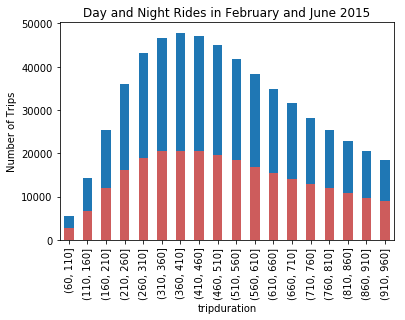

In [97]:
# plotting day trip duration 
bins = np.arange(60, 1000, 50)
dayax = feb_june[feb_june.dayride].tripduration.groupby(
    pd.cut(feb_june[feb_june.dayride].tripduration, bins)).agg([count_nonzero]).plot(kind='bar', legend=False)
    
dayax.set_title("Day and Night Rides in February and June 2015")
dayax.set_xlabel("Trip Duration (minutes)")
dayax.set_ylabel("Number of Trips")

# plot nighttime trip duration histogram
feb_june[~feb_june.dayride].tripduration.groupby(
    pd.cut(feb_june[~feb_june.dayride].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False, ax=dayax, 
                                             color='IndianRed')


              count_nonzero
tripduration               
(60, 110]          0.001018
(110, 160]         0.002360
(160, 210]         0.005051
(210, 260]         0.004809
(260, 310]         0.003008
(310, 360]         0.001736
(360, 410]         0.001271
(410, 460]         0.003725
(460, 510]         0.005953
(510, 560]         0.007494
(560, 610]         0.008710
(610, 660]         0.009209
(660, 710]         0.009678
(710, 760]         0.008619
(760, 810]         0.006456
(810, 860]         0.004263
(860, 910]         0.002406
(910, 960]         0.000000


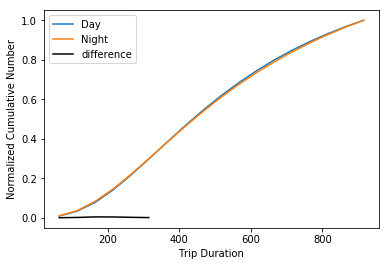

In [99]:
#print df.ageS, df.ageS.cumsum()

csDay = feb_june[feb_june.dayride].tripduration.groupby(pd.cut(feb_june[feb_june.dayride].tripduration, 
                                                 bins)).agg([count_nonzero]).cumsum()

csNight = feb_june[~feb_june.dayride].tripduration.groupby(pd.cut(feb_june[~feb_june.dayride].tripduration, 
                                                  bins)).agg([count_nonzero]).cumsum()

print (np.abs(csDay / csDay.max()-csNight / csNight.max()))

pl.plot(bins[:-1] + 5, csDay / csDay.max(), label = "Day")
pl.plot(bins[:-1] + 5, csNight / csNight.max(), label = "Night")
pl.plot(bins[:-1] + 5, np.sqrt(csNight / csNight.max() - csDay / csDay.max())**2, 'k-',
        label = "difference")
pl.xlabel("Trip Duration")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

**KS Tests to Compare Two Samples**

**Null hypothesis** Two samples come from the same parent distribution. $alpha$=.05

In [111]:
ks = scipy.stats.ks_2samp(feb_june[feb_june.dayride].tripduration, feb_june[~feb_june.dayride].tripduration)
print (ks)


Ks_2sampResult(statistic=0.012400661792634804, pvalue=5.1269005641909511e-33)


**RESULT** We reject the null hypothesis since our p-value is substantially below our alpha for .05

**Reducing dataset**

In [121]:
#more rides during the day than during the night: subsample day rides
df_D = feb_june[feb_june.dayride].iloc[np.random.choice(range(len(feb_june[feb_june.dayride])), (~feb_june.dayride).sum(), 
                                      replace=False)]

In [122]:
pearsons = scipy.stats.pearsonr(np.sort(df_D.tripduration), np.sort(feb_june[~feb_june.dayride].tripduration))
print ("Pearson's test result is: ", pearsons)
if pearsons[1] >= .05: 
    print (r"The Null hypothesis that the two samples are generated from uncorrelated distributions " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions " + 
           "is rejected (p = %.3f<0.05)"%pearsons[1])

Pearson's test result is:  (0.97158575725201601, 0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions is rejected (p = 0.000<0.05)


**Spearman's test**

In [123]:
spearman = scipy.stats.spearmanr(np.sort(df_D.tripduration), np.sort(feb_june[~feb_june.dayride].tripduration))
print ("Spearman's test result: ", spearman)
if spearman[1] >= .05: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions " + 
           "is rejected (p = %.3f<0.05)"%spearman[1])

Spearman's test result:  SpearmanrResult(correlation=0.99999933214913295, pvalue=0.0)
The Null hypothesis that the two samples are generated from uncorrelated distributions is rejected (p = 0.000<0.05)
